# The Exacerbation of Permutation Invariance and Overfitting in Federated Learning of Regression Tasks

In this notebook, we demonstrate that when performing federated learning of regression tasks, the issues of permutation
invariance and client-level overfitting are significantly more prominent. We observe that the fact that regression uses
real outputs leads significant variance in client's optimal weights since there are infinitely many weighted sums that
can lead to the correct output. In federated learning, clients hold non-i.i.d. datasets to eachother and may perform
many steps of model updates before synchronising with the rest of the system, this results in client models that may
individually fit well to a subset of the data but are so significantly different in weights to eachother that the aggregated
model does not fit well to any of the data. We call this effect client-level overfitting.

To start our demonstration we import the required external libraries, and establish constants.

In [1]:
from abc import ABC, abstractmethod
from typing import NamedTuple, Tuple, List, Callable, Dict
from collections import namedtuple
from functools import partial
from numpy.typing import NDArray, ArrayLike
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import jaxopt
import optax
import math
import functools
import sklearn.datasets as skd
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
import scipy.optimize as sp_opt
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt


seed = round(np.pi**12 + np.e * 21)
batch_size = 200
num_epochs = 25
num_clients = 10
num_rounds = num_epochs * num_clients


# Function for evaluating the test performance of a model
def evaluate(Y_test: NDArray, preds: ArrayLike) -> Dict[str, float]:
    return {"R2 score": skm.r2_score(Y_test, preds), "MAE": skm.mean_absolute_error(Y_test, preds)}


# Abstract class for the models
class Model(ABC):
    @abstractmethod
    def set_weights(self, weights: List[NDArray]):
        pass

    @abstractmethod
    def get_weights(self) -> List[NDArray]:
        pass

    @abstractmethod
    def fit(self, X: NDArray, Y: NDArray, batch_size: int, epochs: int, verbose: int) -> float:
        pass

    @abstractmethod
    def predict(self, X: NDArray, batch_size: int):
        pass

We will use the California housing dataset, which is a regression task where information about a house and its area is used to predict its
price in units of hundreds of thousands of dollars. The dataset is automatically attained from https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html.
This dataset allows us to present the simplest format of this demonstration.

In [2]:
X, Y = skd.fetch_california_housing(return_X_y=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Centralised Machine Learning

First, we will show that an equivalent centralised machine learning setting can effectively learn the task.

For our model, we use a simple multilayer perceptron. We can see that it attains good performance when trained locally on the entire training dataset with the Adam optimiser.

In [4]:
class Net(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = nn.sigmoid(x)
        x = nn.Dense(1)(x)
        x = nn.relu(x)
        return x


def mean_absolute_error(model):
    def _apply(variables, X, Y):
        return jnp.mean(jnp.abs(Y - model.apply(variables, X).reshape(-1)))
    return _apply


# Caching is used since these objects are the functionally the same across clients,
# so it saves jit compilations
@functools.cache
def get_adam_solver():
    solver = jaxopt.OptaxSolver(mean_absolute_error(Net()), optax.adam(0.001))
    return solver, jax.jit(solver.update)


@functools.cache
def get_sgd_solver():
    solver = jaxopt.OptaxSolver(mean_absolute_error(Net()), optax.sgd(0.1))
    return solver, jax.jit(solver.update)


class NNModel(Model):
    def __init__(self, input_shape, optimizer="adam", seed=52):
        self.model = Net()
        self.parameters = self.model.init(jax.random.PRNGKey(seed), jnp.zeros((1,) + input_shape))
        self.params_structure = jax.tree_util.tree_structure(self.parameters)
        if optimizer == "adam":
            solver, self.solver_step = get_adam_solver()
        else:
            solver, self.solver_step = get_sgd_solver()
        self.state = solver.init_state(self.parameters, X=jnp.zeros((1,) + input_shape), Y=jnp.zeros((1,)))
        self.rng = np.random.default_rng(seed)

    def set_weights(self, weights):
        self.parameters = jax.tree_util.tree_unflatten(self.params_structure, weights)
    
    def get_weights(self):
        return jax.tree_util.tree_leaves(self.parameters)

    def fit(self, X, Y, batch_size=200, epochs=1, verbose=0):
        for e in range(epochs):
            loss = 0.0
            idxs = np.array_split(self.rng.permutation(len(Y)), math.ceil(len(Y) / batch_size))
            if verbose:
                idxs = tqdm(idxs)
            for idx in idxs:
                self.parameters, self.state = self.solver_step(self.parameters, self.state, X[idx], Y[idx])
                loss += self.state.value
                if verbose:
                    idxs.set_postfix_str(f"Loss: {self.state.value:.4g}")
        return loss.item() / math.ceil(len(Y) / batch_size)

    def predict(self, X, batch_size=200):
        idxs = np.array_split(np.arange(len(X)), math.ceil(len(X) / batch_size))
        return np.concatenate([self.model.apply(self.parameters, X[idx]) for idx in idxs])


model = NNModel(X_train[0].shape, seed=seed)
model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)
evaluate(Y_test, model.predict(X_test))

{'R2 score': 0.5714565637539362, 'MAE': 0.5350595829387667}

# Federated Learning

Now, we create a similar setting, but within federated learning. There is one small difference in our setting, data is distributed in a non-i.i.d. manner
across clients.

With that said, we first define a structure to hold each client's data, and a function to distribute the data to each client. The distribution function
is made non-i.i.d. by assigning each client and equidistant mean label and giving them all samples that have labels that are nearest to that mean.

In [5]:
class ClientData(NamedTuple):
    X: NDArray
    Y: NDArray


def non_iid_client_data(X_train: NDArray, Y_train: NDArray) -> List[ClientData]:
    hist, bins = np.histogram(Y_train, 9)
    bin_idx = np.digitize(Y_train, bins) - 1
    all_client_data = []
    for c in range(num_clients):
        idx = bin_idx == c
        all_client_data.append(ClientData(X_train[idx].copy(), Y_train[idx].copy()))
    return all_client_data


def iid_client_data(X_train: NDArray, Y_train: NDArray, seed: int = 42) -> List[ClientData]:
    rng = np.random.default_rng(seed)
    data_per_client = len(Y_train) // num_clients
    all_client_data = []
    for c in range(num_clients):
        cidx = rng.choice(len(Y_train), data_per_client, replace=False)
        all_client_data.append(ClientData(X_train[cidx].copy(), Y_train[cidx].copy()))
        X_train, Y_train = np.delete(X_train, cidx, axis=0), np.delete(Y_train, cidx, axis=0)
    return all_client_data


def mixed_iid_client_data(X_train: NDArray, Y_train: NDArray, proportion_iid: float = 0.5, seed: int = 42) -> List[ClientData]:
    rng = np.random.default_rng(seed)
    if proportion_iid == 1.0:
        return iid_client_data(X_train, Y_train)
    if proportion_iid == 0.0:
        return non_iid_client_data(X_train, Y_train)
    
    iid_idx = rng.choice(len(Y_train), round(len(Y_train) * proportion_iid), replace=False)
    all_iid_data = iid_client_data(X_train[iid_idx].copy(), Y_train[iid_idx].copy())
    all_non_iid_data = non_iid_client_data(np.delete(X_train.copy(), iid_idx, axis=0), np.delete(Y_train.copy(), iid_idx, axis=0))
    all_client_data = [
        ClientData(np.concatenate((iidd.X, niidd.X)), np.concatenate((iidd.Y, niidd.Y)))
        for iidd, niidd in zip(all_iid_data, all_non_iid_data)
    ]
    return all_client_data

We next define our federated optimisers: federated averaging and FedAdam.

In [6]:
def fedavg(
    client_parameters: List[List[NDArray]],
    client_samples: List[int],
    *_args
) -> List[NDArray]:
    agg_parameters = []
    num_layers = len(client_parameters[0])
    for i in range(num_layers):
        agg_parameters.append(
            np.average([cp[i] for cp in client_parameters], weights=client_samples, axis=0)
        )
    return agg_parameters


class FedAdam:
    def __init__(
        self,
        learning_rate: float = 0.01,
        beta_1: float = 0.9,
        beta_2: float = 0.999,
        epsilon: float = 1e-07
    ):
        self.mu = None
        self.nu = None
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

    def __call__(
        self,
        client_parameters: List[List[NDArray]],
        client_samples: List[int],
        global_parameters: List[NDArray]
    ) -> List[NDArray]:
        if self.mu is None:
            self.mu = [np.zeros_like(p) for p in global_parameters]
            self.nu = [np.zeros_like(p) for p in global_parameters]

        client_grads = [
            [cp - gp for cp, gp in zip(cparams, global_parameters)] for cparams in client_parameters
        ]
        agg_grads = fedavg(client_grads, client_samples)
        for i in range(len(global_parameters)):
            self.mu[i] = self.beta_1 * self.mu[i] + (1 - self.beta_1) * agg_grads[i]
            self.nu[i] = self.beta_2 * self.nu[i] + (1 - self.beta_2) * agg_grads[i]**2
            mu_hat = self.mu[i] / (1 - self.beta_1)
            nu_hat = self.nu[i] / (1 - self.beta_2)
            layer_update = mu_hat / (np.sqrt(nu_hat) + self.epsilon)
            global_parameters[i] += self.learning_rate * layer_update
        return global_parameters

And finally, we define a function to perform our federated learning experiment by creating the clients, having them train for each round, aggregate the client models
using the specified optimizer at the end of each round. When learning is completed, we print the $R^2$ score and mean absolute error of the learnt global model evaluated
on the testing dataset.

In [7]:
def federated_learning(
    create_model_fun: Callable[[Tuple[int]], Model],
    optimiser: Callable[[List[List[NDArray]], List[int], List[NDArray]], List[NDArray]],
    all_client_data: List[ClientData],
    seed: int = 32,
    verbose: int = 1,
) -> Dict[str, float]:
    global_model = create_model_fun(X_train[0].shape, seed=seed)
    client_models = [create_model_fun(X_train[0].shape) for _ in range(num_clients)]
    num_client_samples = [len(cd.Y) for cd in all_client_data]

    pbar = trange(num_rounds) if verbose else range(num_rounds)
    for r in pbar:
        losses = []
        for client_model, client_data in zip(client_models, all_client_data):
            client_model.set_weights(global_model.get_weights())
            loss = client_model.fit(client_data.X, client_data.Y, batch_size=batch_size, verbose=0)
            losses.append(loss)
        global_model.set_weights(
            optimiser([cm.get_weights() for cm in client_models], num_client_samples, global_model.get_weights())
        )
        if verbose:
            pbar.set_postfix_str(f"Loss: {np.average(losses, weights=num_client_samples):.3f}")

    return evaluate(Y_test, global_model.predict(X_test))

We are now set up for the experiments, first we demonstrate with the same model as the centralised training and federated averaging as
the federated optimiser.

In [8]:
federated_learning(NNModel, fedavg, non_iid_client_data(X_train, Y_train))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': -0.13242026716911925, 'MAE': 0.9024728015329302}

We see that this form of training is completely ineffective, so we try a different federated optimiser, FedAdam.

In [9]:
federated_learning(NNModel, FedAdam(), non_iid_client_data(X_train, Y_train))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': -0.0997041685079536, 'MAE': 0.8776277797661824}

It remains arguable that this effect could simple be a side effect of the client-side Adam optimiser being used in training, and the updates
it produces which have differing denominators causing incorrect aggregation. However, with the following we construct a closer replication of
the centralised setting by applying the SGD optimiser at the client-side and FedAdam at the server. Still, we see that client-level
overfitting has a significant negative impact on the resulting global model performance.

In [10]:
federated_learning(functools.partial(NNModel, optimizer="sgd"), FedAdam(), non_iid_client_data(X_train, Y_train))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': -0.054714319262588296, 'MAE': 0.8933072098716099}

### With i.i.d. Data

With the following we show that this effect is not present when the data is i.i.d. with respect to the clients.

In [19]:
federated_learning(NNModel, fedavg, iid_client_data(X_train, Y_train))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': 0.6368760816153459, 'MAE': 0.4922829451032722}

But, model performance is still significantly impacted with there is a mixture of non-i.i.d. (majority) and i.i.d. data across clients.

In [12]:
federated_learning(NNModel, fedavg, mixed_iid_client_data(X_train, Y_train, 0.4))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': 0.05622513748049218, 'MAE': 0.8472273997406442}

# Ridge Regression

In this section we evaluate the same experiments with the ridge regression model.

In [13]:
class RidgeModel(Model):
    def __init__(self, input_shape, alpha=1.0, **_kwargs):
        self.alpha = alpha
        self.parameters = np.zeros(input_shape)

    def set_weights(self, weights):
        self.parameters = weights[0]
    
    def get_weights(self):
        return [self.parameters]

    def fit(self, X, Y, epochs=4, **_kwargs):
        # The default number of epochs makes up for the fact that there are no longer minibatches
        info = sp_opt.minimize(
            partial(RidgeModel.func, X, Y, self.alpha),
            x0=self.parameters,
            method="L-BFGS-B",
            tol=1e-6,
            bounds=[(0, np.inf)] * X.shape[1],
            jac=True,
            options={"maxiter": epochs}
        )
        self.parameters = info['x']
        return info['fun'] / X.shape[1]

    def predict(self, X, **_kwargs):
        return X.dot(self.parameters)

    def func(X, Y, alpha, w):
        residual = X.dot(w) - Y
        f = 0.5 * residual.dot(residual) + 0.5 * alpha * w.dot(w)
        grad = X.T @ residual + alpha * w
        return f, grad

In the centralised setting, we see that the model achieves good performance, although not as good as the neural network.

In [14]:
model = RidgeModel(X_train[0].shape)
model.fit(X_train, Y_train, epochs=num_epochs)
evaluate(Y_test, model.predict(X_test))

{'R2 score': 0.49712158613770574, 'MAE': 0.6222782830202925}

Federated learning with i.i.d. client data converges as expected.

In [15]:
federated_learning(RidgeModel, fedavg, iid_client_data(X_train, Y_train))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': 0.49680218738825166, 'MAE': 0.6239951431886539}

While non-i.i.d. client data prevents convergence.

In [16]:
federated_learning(RidgeModel, fedavg, non_iid_client_data(X_train, Y_train))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': -0.08329586788357024, 'MAE': 0.9461897999595704}

An the same when FedAdam is used.

In [17]:
federated_learning(RidgeModel, FedAdam(), non_iid_client_data(X_train, Y_train))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': -0.3523827396911543, 'MAE': 1.0599914054378345}

Although, we see better results with partially i.i.d. data.

In [18]:
federated_learning(RidgeModel, fedavg, mixed_iid_client_data(X_train, Y_train, 0.4))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': 0.17453841346802523, 'MAE': 0.8254006346432428}

# Varying the level of i.i.d.

In this section, we evaluate the pefromance of the two models across varying proportions of non-i.i.d. data across clients.

In [20]:
def iid_level_experiment(create_model_fun, repeats=10):
    experiment_results = []
    for r in trange(repeats):
        performance = []
        seed = round(np.pi**12 + np.e*21 + r)
        for piid in np.linspace(0.0, 1.0, 11):
            results = federated_learning(create_model_fun, fedavg, mixed_iid_client_data(X_train, Y_train, piid, seed=seed), seed=seed, verbose=0)
            performance.append(results['R2 score'])
        tqdm.write(f"repetition {r}: {performance=}")
        experiment_results.append(performance)
    return experiment_results

First, we evaluate the Ridge Regression model, an find a consistiant increase in performance as the proportion of i.i.d. client data increases.

In [21]:
ridge_results = iid_level_experiment(RidgeModel, repeats=30)

  0%|          | 0/30 [00:00<?, ?it/s]

repetition 0: performance=[-0.08329586788357024, 0.11604454445364898, 0.11024143931488306, 0.3665041588910187, 0.3076141632653766, 0.2678214330192744, 0.25709694747603884, 0.3025861021878884, 0.3105866495584997, 0.48992806434597747, 0.49680218738825166]
repetition 1: performance=[-0.08329586788357024, 0.11846433579798954, 0.17685273612079244, 0.2373260502765817, 0.36579391124365235, 0.25893931597801034, 0.30687508167880717, 0.47276926394993934, 0.4128013902784702, 0.40938843952061443, 0.49680218738825166]
repetition 2: performance=[-0.08329586788357024, 0.10482438312072495, 0.16660515980886315, 0.23012160991925001, 0.31797048828033014, 0.32343555450919015, 0.2955514811339379, 0.31771564750371994, 0.4040076519147381, 0.3904790358285595, 0.49680218738825166]
repetition 3: performance=[-0.08329586788357024, 0.08489502806296856, 0.15713365762421316, 0.22057245217387667, 0.34330731826454586, 0.255969238664999, 0.28480663819513463, 0.321795684676245, 0.3488980830068181, 0.39217739393859163, 

In [22]:
nn_results = iid_level_experiment(NNModel, repeats=30)

  0%|          | 0/30 [00:00<?, ?it/s]

repetition 0: performance=[-0.14395105312870715, -0.131448171558588, -0.11658720147539237, -0.05488152067149832, 0.0009064534017789727, 0.08091004672965008, 0.5102334699842193, 0.5716412146747387, 0.5940775447179577, 0.618707800973933, 0.6153881960657541]
repetition 1: performance=[-3.1943024967426563, -3.1943024967426563, -3.1943024967426563, -3.1943024967426563, -3.1943024967426563, -3.1943024967426563, -3.1943024967426563, -3.1943024967426563, -3.1943024967426563, -3.1943024967426563, -3.1943024967426563]
repetition 2: performance=[-0.1445474479426756, -0.12751108562572622, -0.09959319877658412, -0.06828744891974292, -0.05766944632120086, 0.09853166616884557, 0.12777989998075312, 0.39310354187663155, 0.4801717148044262, 0.5349204406601084, 0.5353492551720019]
repetition 3: performance=[-0.12828674474748514, -0.1287520094762178, -0.11265405512090454, -0.027603403490538803, 0.1392108607438154, 0.2402533910337873, 0.5170773489953424, 0.568346460957061, 0.6026341910061142, 0.62618698276

To visualise the differences between the models in terms of performance, we first remove outliers using the local outlier factor, then plot the mean $R^2$ scores with respect to the proportion of i.i.d. data.
We can see that the ridge regression model is more resilient to non-i.i.d. data due to the smaller optimal parameter space cause by the regularisation term, however, it still suffers from negative impacts
and in the best conditions, it does not perform as well as the neural network.

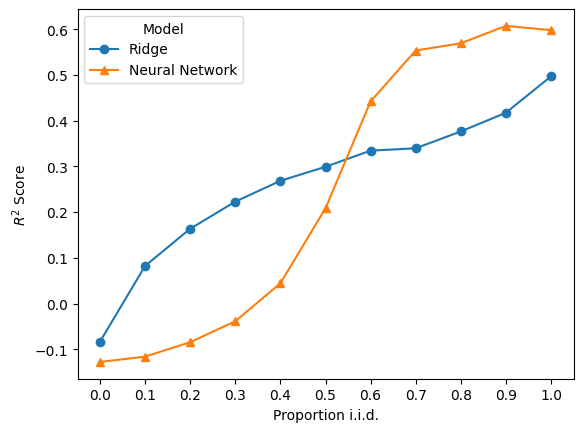

In [23]:
from sklearn.neighbors import LocalOutlierFactor

def clean_summarise_results(results: List[List[float]]):
    results = np.array(results)
    inliers = LocalOutlierFactor().fit_predict(results) > 0
    return results[inliers]

nn_results = clean_summarise_results(nn_results)
ridge_results = clean_summarise_results(ridge_results)

plt.plot(np.linspace(0.0, 1.0, ridge_results.shape[-1]), ridge_results.mean(axis=0), '-o', label="Ridge")
plt.plot(np.linspace(0.0, 1.0, nn_results.shape[-1]), nn_results.mean(axis=0), '-^', label="Neural Network")
plt.ylabel("$R^2$ Score")
plt.xlabel("Proportion i.i.d.")
plt.xticks(np.linspace(0.0, 1.0, 11))
plt.legend(title="Model")
plt.show()

# Applying the Ridge Term in Neural Network Learning

Given that we see benefits in applying rigde regression when learning hightly non-i.i.d. data, another question is posed of ''what happens when the ridge term is used in the neural network loss function?''
In the following, we explore this question. First we define the model and shoe that it remains effective at centralised learning with performance close to the neural network alone.

In [24]:
def reg_mae(model, lamb=0.5):
    def _apply(variables, X, Y):
        reg = sum((l**2).mean() for l in jax.tree_util.tree_leaves(variables))
        return jnp.mean(jnp.abs(Y - model.apply(variables, X).reshape(-1))) + lamb * reg
    return _apply


@functools.cache
def get_reg_adam_solver():
    solver = jaxopt.OptaxSolver(reg_mae(Net()), optax.adam(0.001))
    return solver, jax.jit(solver.update)


@functools.cache
def get_reg_sgd_solver():
    solver = jaxopt.OptaxSolver(reg_mae(Net()), optax.sgd(0.1))
    return solver, jax.jit(solver.update)


class RegNNModel(NNModel):
    def __init__(self, input_shape, optimizer="adam", seed=52):
        super().__init__(input_shape, optimizer, seed)
        if optimizer == "adam":
            solver, self.solver_step = get_reg_adam_solver()
        else:
            solver, self.solver_step = get_reg_sgd_solver()
        self.state = solver.init_state(self.parameters, X=jnp.zeros((1,) + input_shape), Y=jnp.zeros((1,)))

model = RegNNModel(X_train[0].shape, seed=seed)
model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)
evaluate(Y_test, model.predict(X_test))

{'R2 score': 0.5880288336851123, 'MAE': 0.5274157266378449}

Next, as expected, we see that each variation of federated learning of non-iid data is ineffective.

In [25]:
federated_learning(RegNNModel, fedavg, non_iid_client_data(X_train, Y_train))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': -0.11646710905334312, 'MAE': 0.8989202141586939}

In [26]:
federated_learning(RegNNModel, FedAdam(), non_iid_client_data(X_train, Y_train))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': -0.0437913514092787, 'MAE': 0.8853426853389056}

In [27]:
federated_learning(functools.partial(RegNNModel, optimizer="sgd"), FedAdam(), non_iid_client_data(X_train, Y_train))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': 0.0004566515906156976, 'MAE': 0.9225850550357501}

However, for mixed i.i.d. data, performance close to the ridge regression model.

In [28]:
federated_learning(RegNNModel, fedavg, mixed_iid_client_data(X_train, Y_train, 0.4))

  0%|          | 0/250 [00:00<?, ?it/s]

{'R2 score': 0.23574586496664907, 'MAE': 0.7688994706682734}

For completeness, we perform the experiment across all levels of i.i.d.

In [29]:
reg_nn_results = iid_level_experiment(RegNNModel, repeats=30)

  0%|          | 0/30 [00:00<?, ?it/s]

repetition 0: performance=[-0.11192592707260518, -0.1322596420426161, -0.07385795046132326, -0.00519540230496518, 0.06718438032262297, 0.4071904100103986, 0.5489638347439523, 0.5723903074655061, 0.628410562614842, 0.6351714564550612, 0.624345895177466]
repetition 1: performance=[-0.0550205746045489, -0.05628067424848404, -0.053081710662206794, -0.0022361402986299517, 0.18201062115914413, 0.41556980904603824, 0.5336919340298589, 0.5750339464488007, 0.6097539021564616, 0.631914599484066, 0.6156611915736078]
repetition 2: performance=[-0.06779830936148912, -0.09655528318833251, -0.0476464495031268, 0.021902845572911334, 0.17275618772723966, 0.38240630323308056, 0.5333545879050245, 0.5730873257991095, 0.5896025267811471, 0.6276096370832124, 0.6299467601373188]
repetition 3: performance=[-0.15397922438077094, -0.12025550576792665, -0.037695909557633245, -0.01443155795238571, 0.11878068802378772, 0.41109255704658565, 0.57006796912401, 0.571247429262852, 0.609632993698516, 0.6349413023063002,

Plotting the results, we see that adding the ridge term to the neural network model improves the performance of the standard neural network, however,
the ridge regression model still remains better when the data is highly non-i.i.d.

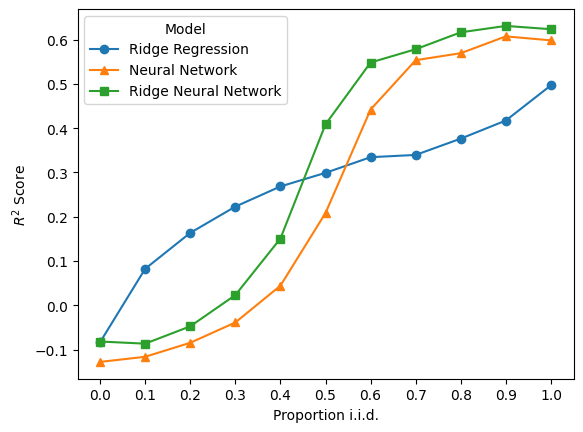

In [30]:
reg_nn_results = clean_summarise_results(reg_nn_results)

plt.plot(np.linspace(0.0, 1.0, ridge_results.shape[-1]), ridge_results.mean(axis=0), '-o', label="Ridge Regression")
plt.plot(np.linspace(0.0, 1.0, nn_results.shape[-1]), nn_results.mean(axis=0), '-^', label="Neural Network")
plt.plot(np.linspace(0.0, 1.0, reg_nn_results.shape[-1]), reg_nn_results.mean(axis=0), '-s', label="Ridge Neural Network")
plt.ylabel("$R^2$ Score")
plt.xlabel("Proportion i.i.d.")
plt.xticks(np.linspace(0.0, 1.0, 11))
plt.legend(title="Model")
plt.show()